# Fidelity Calculation

In [122]:
# Enabling the `widget` backend.print(totalFinalStates[1][zero_amplitude])
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib inline

from itertools import product, combinations
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
from qiskit.providers.aer import noise
from qiskit.quantum_info import Operator, average_gate_fidelity, state_fidelity

from numpy import pi
from math import e
from matplotlib import colors, cm
from matplotlib.ticker import PercentFormatter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter)

import matplotlib.pyplot as plt
import numpy as np
import math

In [123]:
def prepareInitialStatesFixedPhase(pointsTheta, Phase):
    """ Prepare initial states to pass through the circuit """
    """ with a fixed Phase angle. Only moving across Theta """
    
    # As we have to provide the state values to initialize the qreg[0] we have to do a conversion
    # from angles in the sphere to statevector amplitudes. These statevectors will be the combination of
    # Zero_Amplitude*|0> plus One_Amplitude*|1>
    initialStates = []
    
    for theta in np.mgrid[0:pi:pointsTheta*1j]:
        a = math.cos(theta/2)
        b = math.sin(theta/2)*e**(1j*Phase)
        norm = np.sqrt(a*np.conj(a)+b*np.conj(b))
        if norm > 1:
            initialStates.append([a/norm, b/norm])
        else:
            initialStates.append([a, b])
            
    return np.array(initialStates)

In [124]:
def calculate_fidelity(initialStates, eta, circ):
    stavec = []
    statevector = []
    fidelity = []
    for i in range(len(initialStates)):
        circ.initialize([initialStates[i][0], initialStates[i][1]], qreg_q[0])
        circ.reset(qreg_q[1])
        circ.cry(eta, qreg_q[0], qreg_q[1])
        circ.cx(qreg_q[1], qreg_q[0])
        res = execute(circ, backend_sim).result() 
        sv = res.get_statevector(circ)
        stavec.append([sv[0],sv[1]])
        fidelity.append([state_fidelity([initialStates[i][0], initialStates[i][1]], [sv[0], sv[1]], validate=False), state_fidelity([1, 0], [sv[0], sv[1]], validate=False)])
    return np.array(fidelity)

In [129]:
pointsTheta = 20  # Points of Theta angle (pi) in Bloch sphere - min 2
Phase = 0         # Angle for Phase
anglesEta = np.arange(0, pi, 2*pi/(pointsTheta))      # Circuit angles for CY

qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(qreg_q, creg_c)

initialStates = prepareInitialStatesFixedPhase(pointsTheta, Phase)

backend_sim = Aer.get_backend('statevector_simulator')

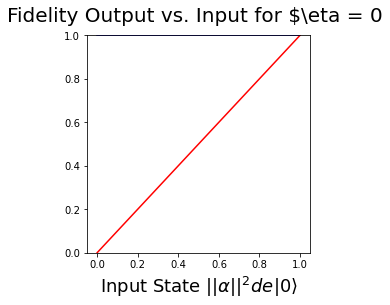

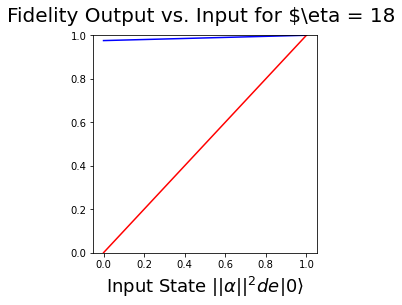

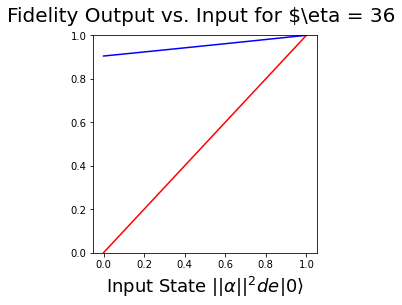

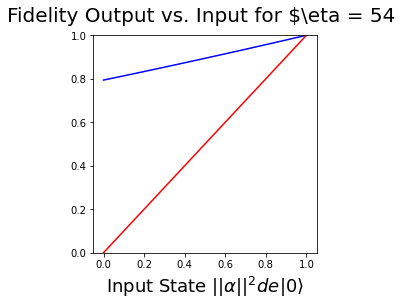

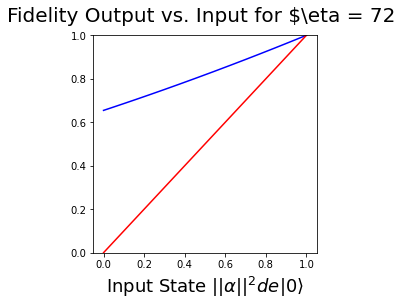

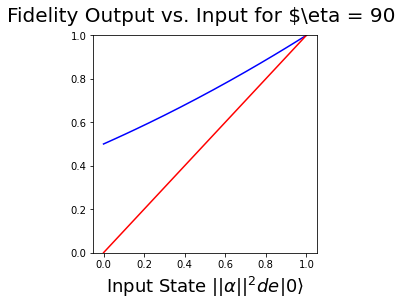

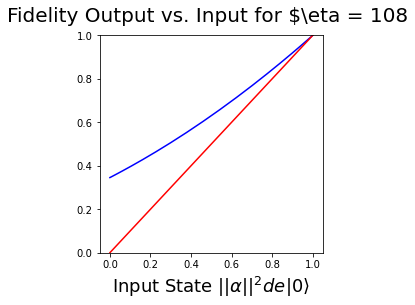

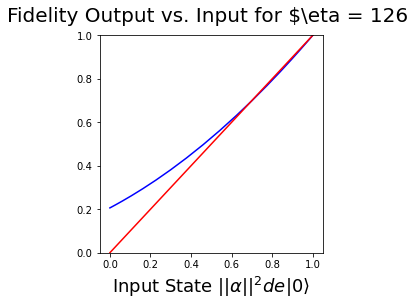

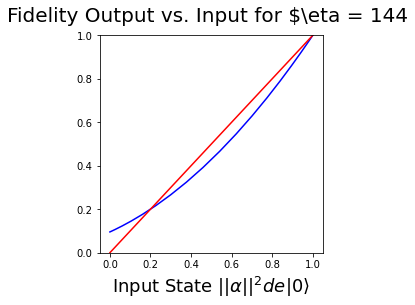

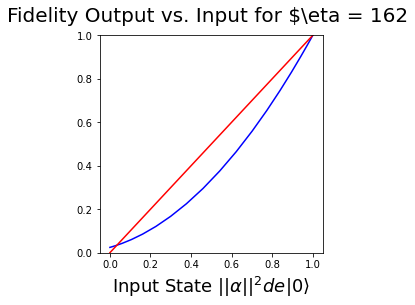

In [131]:
#Representation of fidelity
for eta in anglesEta:
    X = []
    Y = []
    Z = []
    fidelity = calculate_fidelity(initialStates, eta, circ)
    for i in range(len(initialStates)):
        X.append((initialStates[i][0]*np.conj(initialStates[i][0])).real)
        Y.append(fidelity[i][0])
        Z.append(fidelity[i][1])
    fig = plt.figure(figsize=(4,4))
    fig.suptitle('Fidelity Output vs. Input for ' + '$\\eta = ' + str(int(math.degrees(eta))), fontsize=20)
    plt.xlabel('Input State ||' + '$\\alpha||^2 de |0\\rangle$', fontsize=18)
    #plt.ylabel('ylabel', fontsize=16)
    #fig.savefig('test.jpg')
    #ax.plot(y, color='blue', label='Sine wave')
    #ax.plot(z, color='black', label='Cosine wave')

    plt.plot(X, Y, color='blue', label='Fidelity versus initial state')
    plt.plot(X, Z, color='red', label='Fidelity versus |0> state')
    plt.ylim([0, 1])
    plt.show()